In [1]:
# =============================================================================
# Cell 1: Import Required Libraries
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from scipy.sparse import hstack
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [2]:
# =============================================================================
# Cell 2: Load Preprocessed Data
# =============================================================================

# Load the preprocessed dataset from previous step
df = pd.read_csv('../src/data/processed/temu_reviews_preprocessed.csv')

print(f"Dataset loaded with {len(df)} reviews")
print(f"Columns: {df.columns.tolist()}")
print(f"Target variable distribution:")
print(df['ReviewRating'].value_counts().sort_index())

Dataset loaded with 13855 reviews
Columns: ['UserId', 'UserName', 'UserCountry', 'ReviewCount', 'ReviewRating', 'ReviewTitle', 'ReviewText', 'processed_text', 'ReviewDate', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 'exclamation_count', 'question_count', 'capital_ratio', 'sentiment_compound', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']
Target variable distribution:
ReviewRating
1    7219
2     878
3     655
4    1125
5    3978
Name: count, dtype: int64


In [3]:
# =============================================================================
# Cell 3: Prepare Text Data for TF-IDF
# =============================================================================

# Remove rows with empty processed text
df_clean = df[df['processed_text'].str.len() > 0].copy()
print(f"After removing empty texts: {len(df_clean)} reviews")

# Separate features and target
X_text = df_clean['processed_text']
y = df_clean['ReviewRating']

print(f"Text features shape: {X_text.shape}")
print(f"Target shape: {y.shape}")

After removing empty texts: 13723 reviews
Text features shape: (13723,)
Target shape: (13723,)


In [4]:
# =============================================================================
# Cell 4: Create TF-IDF Vectors
# =============================================================================

# TF-IDF converts text to numerical features
# max_features=5000 limits to top 5000 words to avoid overfitting
# min_df=2 requires word to appear in at least 2 documents
# max_df=0.95 excludes words that appear in more than 95% of documents
# ngram_range=(1, 2) Include single words and pairs and if we would include trigrams (1, 3) 
# it will increase the feature size significantly and may lead to overfitting

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    stop_words='english',
    ngram_range=(1, 2)
)

print("Creating TF-IDF vectors...")
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Number of unique words/phrases: {len(tfidf_vectorizer.vocabulary_)}")

Creating TF-IDF vectors...
TF-IDF matrix shape: (13723, 5000)
Number of unique words/phrases: 5000


Top 30 words by TF-IDF score:
temu: 0.0429
item: 0.0407
order: 0.0385
good: 0.0253
time: 0.0244
ordered: 0.0231
product: 0.0224
quality: 0.0220
delivery: 0.0215
customer: 0.0213
refund: 0.0209
service: 0.0197
price: 0.0193
company: 0.0191
dont: 0.0186
received: 0.0172
money: 0.0171
return: 0.0161
free: 0.0158
ive: 0.0156
like: 0.0156
day: 0.0155
great: 0.0152
thing: 0.0145
customer service: 0.0144
buy: 0.0142
package: 0.0140
cheap: 0.0139
got: 0.0139
delivered: 0.0138


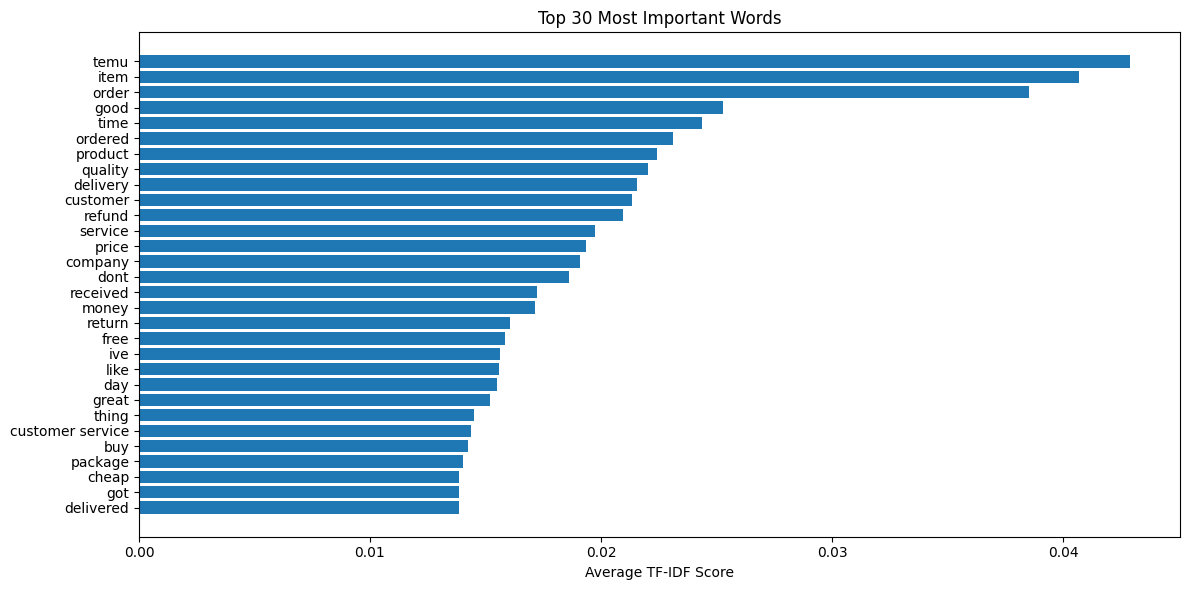

In [5]:
# =============================================================================
# Cell 5: Analyze Most Important Words
# =============================================================================

# Get feature names and their importance
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = np.array(X_tfidf.mean(axis=0)).flatten()

# Get top words by TF-IDF score
top_indices = tfidf_scores.argsort()[-30:][::-1]
top_words = [(feature_names[i], tfidf_scores[i]) for i in top_indices]

print("Top 30 words by TF-IDF score:")
for word, score in top_words:
    print(f"{word}: {score:.4f}")

# Visualize top words
plt.figure(figsize=(12, 6))
words, scores = zip(*top_words)
plt.barh(range(len(words)), scores)
plt.yticks(range(len(words)), words)
plt.xlabel('Average TF-IDF Score')
plt.title('Top 30 Most Important Words')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [10]:
# =============================================================================
# Cell 6: Analyze Words by Rating
# =============================================================================

# Find words that are most associated with each rating
def get_top_words_by_rating(rating, n_words=10):
    """Get top words for a specific rating"""
    rating_mask = df_clean['ReviewRating'] == rating
    rating_tfidf = X_tfidf[rating_mask.values]
    
    if rating_tfidf.shape[0] == 0:
        return []
    
    # Calculate mean TF-IDF for this rating
    mean_tfidf = np.array(rating_tfidf.mean(axis=0)).flatten()
    
    # Get top words
    top_indices = mean_tfidf.argsort()[-n_words:][::-1]
    top_words = [(feature_names[i], mean_tfidf[i]) for i in top_indices]
    
    return top_words

# Analyze words for each rating
print("Top words by rating:")
print("=" * 50)
for rating in [1, 2, 3, 4, 5]:
    top_words = get_top_words_by_rating(rating, 10)
    print(f"\nRating {rating}:")
    for word, score in top_words[:10]:  # Show top 10
        print(f"  {word}: {score:.4f}")

Top words by rating:

Rating 1:
  temu: 0.0418
  order: 0.0383
  item: 0.0377
  refund: 0.0274
  customer: 0.0268
  company: 0.0235
  money: 0.0233
  dont: 0.0232
  service: 0.0220
  time: 0.0207

Rating 2:
  item: 0.0436
  order: 0.0406
  temu: 0.0351
  time: 0.0247
  ordered: 0.0244
  free: 0.0244
  delivery: 0.0223
  quality: 0.0215
  good: 0.0207
  product: 0.0206

Rating 3:
  item: 0.0488
  order: 0.0389
  temu: 0.0360
  good: 0.0349
  product: 0.0328
  time: 0.0291
  delivery: 0.0243
  like: 0.0234
  quality: 0.0230
  free: 0.0212

Rating 4:
  item: 0.0511
  good: 0.0477
  temu: 0.0417
  order: 0.0371
  quality: 0.0317
  price: 0.0312
  time: 0.0281
  product: 0.0268
  thing: 0.0261
  great: 0.0250

Rating 5:
  temu: 0.0482
  good: 0.0419
  item: 0.0413
  order: 0.0388
  great: 0.0381
  price: 0.0361
  quality: 0.0356
  ordered: 0.0306
  time: 0.0292
  delivery: 0.0287


In [6]:
# =============================================================================
# Cell 7: Prepare Additional Features
# =============================================================================

# Select numerical features to combine with TF-IDF
numerical_features = [
    'word_count', 'char_count', 'sentence_count', 'avg_word_length',
    'exclamation_count', 'question_count', 'capital_ratio',
    'sentiment_compound', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg'
]

# Get numerical features for clean dataset
X_numerical = df_clean[numerical_features].values

print(f"Numerical features shape: {X_numerical.shape}")
print(f"Numerical features: {numerical_features}")

# Check for missing values
print(f"Missing values in numerical features: {np.isnan(X_numerical).sum()}")

Numerical features shape: (13723, 11)
Numerical features: ['word_count', 'char_count', 'sentence_count', 'avg_word_length', 'exclamation_count', 'question_count', 'capital_ratio', 'sentiment_compound', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']
Missing values in numerical features: 0


In [8]:
# =============================================================================
# Cell 8: Scale Numerical Features
# =============================================================================

# Scale numerical features to have similar range as TF-IDF
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

print("Numerical features scaled!")
print(f"Original range example (word_count): {X_numerical[:, 0].min():.2f} to {X_numerical[:, 0].max():.2f}")
print(f"Scaled range example (word_count): {X_numerical_scaled[:, 0].min():.2f} to {X_numerical_scaled[:, 0].max():.2f}")


Numerical features scaled!
Original range example (word_count): 2.00 to 1014.00
Scaled range example (word_count): -0.96 to 10.96


In [9]:
# =============================================================================
# Cell 9: Combine TF-IDF and Numerical Features
# =============================================================================

# Combine TF-IDF vectors with numerical features
# hstack horizontally stacks the feature matrices
X_combined = hstack([X_tfidf, X_numerical_scaled])

print(f"Combined features shape: {X_combined.shape}")
print(f"TF-IDF features: {X_tfidf.shape[1]}")
print(f"Numerical features: {X_numerical_scaled.shape[1]}")
print(f"Total features: {X_combined.shape[1]}")

Combined features shape: (13723, 5011)
TF-IDF features: 5000
Numerical features: 11
Total features: 5011


In [10]:
# =============================================================================
# Cell 10: Split Data for Training and Testing
# =============================================================================

# Split data into training and testing sets
# 80% for training, 20% for testing
# random_state=42 ensures reproducible results
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Check class distribution in train/test sets
print(f"\nTraining set rating distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest set rating distribution:")
print(y_test.value_counts().sort_index())

Training set size: 10978
Test set size: 2745

Training set rating distribution:
ReviewRating
1    5736
2     697
3     518
4     891
5    3136
Name: count, dtype: int64

Test set rating distribution:
ReviewRating
1    1434
2     174
3     130
4     223
5     784
Name: count, dtype: int64


PCA explained variance ratio: [0.26084156 0.1835505  0.13421915 0.09125218 0.0754899  0.07282474
 0.0648083  0.0192278 ]
Total variance explained: 0.902


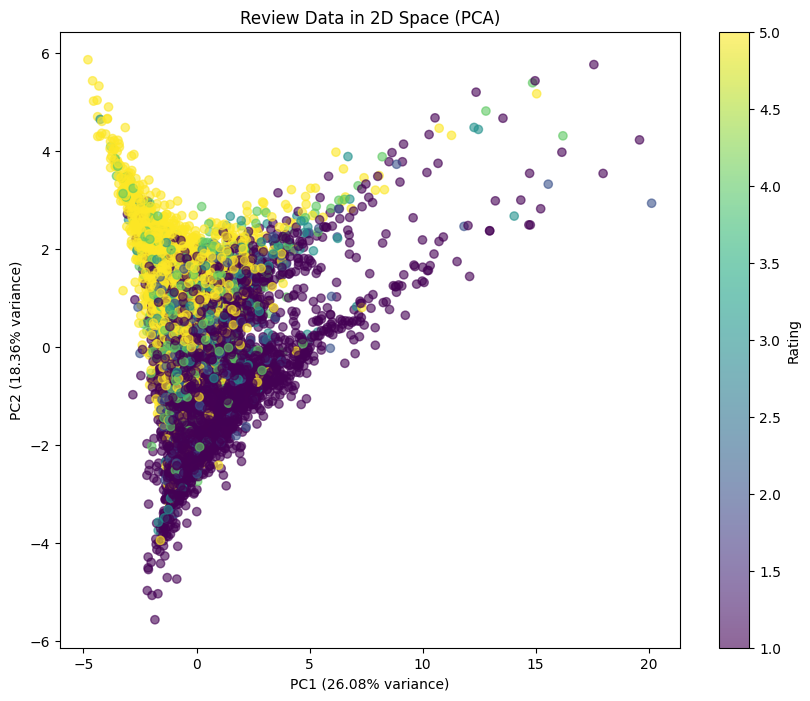

In [11]:
# =============================================================================
# Cell 11: Dimensionality Reduction for Visualization
# =============================================================================

# Use PCA to reduce dimensions for visualization
# This helps us understand the data structure
pca = PCA(n_components=0.9, random_state=42)
X_train_dense = X_train.toarray()  # Convert sparse to dense for PCA
X_pca = pca.fit_transform(X_train_dense)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")

# Visualize data in 2D space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Rating')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Review Data in 2D Space (PCA)')
plt.show();

In [12]:
# =============================================================================
# Cell 12: Feature Importance Analysis
# =============================================================================

# Analyze which features are most important for each rating
def analyze_feature_importance(rating):
    """Analyze which features distinguish a rating from others"""
    rating_mask = (y_train == rating).to_numpy()
    other_mask = (y_train != rating).to_numpy()
    
    # Get mean feature values for rating vs others
    rating_features = X_train[rating_mask].mean(axis=0)
    other_features = X_train[other_mask].mean(axis=0)
    
    # Calculate difference
    feature_diff = rating_features - other_features
    
    return feature_diff

# Analyze importance for each rating
print("Feature importance analysis:")
print("=" * 50)

for rating in [1, 2, 3, 4, 5]:
    feature_diff = analyze_feature_importance(rating)
    
    # Get top distinguishing features
    if hasattr(feature_diff, 'A1'):  # If it's a matrix
        feature_diff = feature_diff.A1
    
    top_indices = np.argsort(feature_diff)[-5:][::-1]
    
    print(f"\nRating {rating} top distinguishing features:")
    for idx in top_indices:
        if idx < len(feature_names):
            print(f"  {feature_names[idx]}: {feature_diff[idx]:.4f}")
        else:
            # This is a numerical feature
            num_idx = idx - len(feature_names)
            print(f"  {numerical_features[num_idx]}: {feature_diff[idx]:.4f}")

Feature importance analysis:

Rating 1 top distinguishing features:
  sentiment_compound: 0.7430
  sentiment_pos: 0.4224
  char_count: 0.2645
  word_count: 0.2580
  sentence_count: 0.2298

Rating 2 top distinguishing features:
  sentiment_pos: 0.2341
  question_count: 0.0970
  sentiment_compound: 0.0755
  sentence_count: 0.0204
  word_count: 0.0139

Rating 3 top distinguishing features:
  sentiment_pos: 0.1660
  sentiment_neg: 0.1311
  word_count: 0.0668
  char_count: 0.0557
  question_count: 0.0211

Rating 4 top distinguishing features:
  sentiment_neg: 0.6362
  sentiment_neu: 0.3825
  good: 0.0235
  thing: 0.0126
  price: 0.0122

Rating 5 top distinguishing features:
  sentiment_neu: 1.1725
  sentiment_neg: 1.1121
  avg_word_length: 0.1022
  great: 0.0316
  love: 0.0262


In [13]:
# =============================================================================
# Cell 13: Create Feature Matrix for Different Approaches
# =============================================================================

# Create different feature combinations for model comparison
feature_combinations = {
    'tfidf_only': X_tfidf,
    'numerical_only': X_numerical_scaled,
    'combined': X_combined
}

# Split each combination
splits = {}
for name, X in feature_combinations.items():
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    splits[name] = {
        'X_train': X_tr,
        'X_test': X_te,
        'y_train': y_tr,
        'y_test': y_te
    }

print("Feature combinations created:")
for name, data in splits.items():
    print(f"{name}: {data['X_train'].shape[1]} features")

Feature combinations created:
tfidf_only: 5000 features
numerical_only: 11 features
combined: 5011 features


In [ ]:
# =============================================================================
# Cell 14: N-gram Analysis - Experiment with Different N-grams
# =============================================================================

# Create additional TF-IDF with different n-grams
ngram_configs = {
    'unigram': (1, 1),
    'bigram': (2, 2),
    'trigram': (3, 3),
    'uni_bigram': (1, 2),
    'uni_bi_trigram': (1, 3)
}

ngram_results = {}
for name, ngram_range in ngram_configs.items():
    vectorizer = TfidfVectorizer(
        max_features=5000,
        min_df=2,
        max_df=0.95,
        stop_words='english',
        ngram_range=ngram_range
    )
    
    X_ngram = vectorizer.fit_transform(X_text)
    ngram_results[name] = {
        'vectorizer': vectorizer,
        'features': X_ngram,
        'n_features': X_ngram.shape[1]
    }

print("N-gram analysis results:")
for name, result in ngram_results.items():
    print(f"{name}: {result['n_features']} features")

N-gram analysis results:
unigram: 5000 features
bigram: 5000 features
trigram: 5000 features
uni_bigram: 5000 features
uni_bi_trigram: 5000 features


In [ ]:
# =============================================================================
# Cell 15: Visualize N-gram Examples - Experiment with Different N-grams
# =============================================================================

# Show examples of different n-grams
print("N-gram examples:")
print("=" * 50)

for name, result in ngram_results.items():
    feature_names = result['vectorizer'].get_feature_names_out()
    print(f"\n{name.upper()} examples:")
    print(f"Sample features: {feature_names[:10]}")

N-gram examples:

UNIGRAM examples:
Sample features: ['abandoned' 'abd' 'ability' 'abit' 'able' 'abroad' 'absence' 'absolute'
 'absolutely' 'absurd']

BIGRAM examples:
Sample features: ['able buy' 'able order' 'able return' 'able track' 'able use'
 'absolute garbage' 'absolute joke' 'absolute rubbish' 'absolute scam'
 'absolutely amazing']

TRIGRAM examples:
Sample features: ['able deliver today' 'able provide reshipmentrefund' 'able return item'
 'able return refund' 'able track order' 'able use coupon'
 'absolutely fantastic service' 'absolutely horrible experience'
 'absolutely love shopping' 'absolutely love site']

UNI_BIGRAM examples:
Sample features: ['ability' 'able' 'able order' 'able return' 'able use' 'absolute'
 'absolute rubbish' 'absolute scam' 'absolutely' 'absolutely disgusting']

UNI_BI_TRIGRAM examples:
Sample features: ['ability' 'able' 'able return' 'able use' 'absolute' 'absolute rubbish'
 'absolute scam' 'absolutely' 'absolutely disgusting' 'absolutely love']


In [16]:
# =============================================================================
# Cell 16: Class Imbalance Analysis
# =============================================================================

# Analyze class imbalance for different approaches
class_counts = y.value_counts().sort_index()
total_samples = len(y)

print("Class imbalance analysis:")
print("=" * 50)
print("Rating distribution:")

for rating, count in class_counts.items():
    percentage = (count / total_samples) * 100
    print(f"Rating {rating}: {count} samples ({percentage:.1f}%)")

# Calculate class weights for imbalanced learning
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weight_dict = dict(zip(np.unique(y), class_weights))

print(f"\nClass weights for balanced learning:")
for rating, weight in weight_dict.items():
    print(f"Rating {rating}: {weight:.3f}")

Class imbalance analysis:
Rating distribution:
Rating 1: 7170 samples (52.2%)
Rating 2: 871 samples (6.3%)
Rating 3: 648 samples (4.7%)
Rating 4: 1114 samples (8.1%)
Rating 5: 3920 samples (28.6%)

Class weights for balanced learning:
Rating 1: 0.383
Rating 2: 3.151
Rating 3: 4.235
Rating 4: 2.464
Rating 5: 0.700


In [17]:
# =============================================================================
# Cell 17: Regression vs Classification Decision
# =============================================================================

print("CLASSIFICATION vs REGRESSION ANALYSIS")
print("=" * 60)

# --- Arguments FOR CLASSIFICATION -------------------------------------------
print("Arguments for CLASSIFICATION:")
print("- Ratings are discrete classes (1, 2, 3, 4, 5).")
print("- The business need is to output the correct star label, not a float.")
print("- Class-imbalance can be handled via class_weight, F1, ROC-AUC, etc.")
print("- Easy to interpret with confusion-matrix, precision-recall curves.")
print("- Wide choice of proven algorithms: Logistic Reg., SVM,")
print("  Gradient Boosting, FastText, Transformer classifiers …")

# --- Arguments FOR REGRESSION (less suited here) ----------------------------
print("\nArguments for REGRESSION (less suited here):")
print("- An ordinal structure exists, BUT:")
print("  * The perceived distance 4↔5 is not necessarily half of 1↔5.")
print("  * Error metrics like RMSE penalise large deviations heavily,")
print("    which can distort training when extreme classes are rare.")
print("- Regression models tend to predict mid-range values (~3 stars).")
print("- Rounding a regression output back to integers loses precision again.")

# --- Check rating distribution ---------------------------------------------
skewness = stats.skew(y)
print(f"\nRating distribution skewness: {skewness:.3f}")
print("(Positive skew ⇒ many low or many high ratings)")

# --- Decision ---------------------------------------------------------------
print("\nDECISION: Proceed with CLASSIFICATION")
print("Reasoning:")
print("1. Business logic demands clear star labels.")
print("2. Class-imbalance tools and metrics (F1, ROC-AUC) fit better.")
print("3. Confusion matrix gives straightforward error analysis.")
print("4. Regression can be revisited later for fine-grained modelling")
print("   of gaps between neighbouring classes if truly needed.")

CLASSIFICATION vs REGRESSION ANALYSIS
Arguments for CLASSIFICATION:
- Ratings are discrete classes (1, 2, 3, 4, 5).
- The business need is to output the correct star label, not a float.
- Class-imbalance can be handled via class_weight, F1, ROC-AUC, etc.
- Easy to interpret with confusion-matrix, precision-recall curves.
- Wide choice of proven algorithms: Logistic Reg., SVM,
  Gradient Boosting, FastText, Transformer classifiers …

Arguments for REGRESSION (less suited here):
- An ordinal structure exists, BUT:
  * The perceived distance 4↔5 is not necessarily half of 1↔5.
  * Error metrics like RMSE penalise large deviations heavily,
    which can distort training when extreme classes are rare.
- Regression models tend to predict mid-range values (~3 stars).
- Rounding a regression output back to integers loses precision again.

Rating distribution skewness: 0.452
(Positive skew ⇒ many low or many high ratings)

DECISION: Proceed with CLASSIFICATION
Reasoning:
1. Business logic deman

In [18]:
# =============================================================================
# Cell 18: Save Feature Engineering Results
# =============================================================================

# Save processed features and splits
import pickle

# Save TF-IDF vectorizer
with open('../src/models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save scaler
with open('../src/models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save train/test splits
with open('../src/models/train_test_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

# Save feature names
feature_info = {
    "tfidf_vectorizer": tfidf_vectorizer,
    'tfidf_features': tfidf_vectorizer.get_feature_names_out().tolist(),
    'numerical_features': numerical_features,
    'feature_count': len(tfidf_vectorizer.get_feature_names_out()),
    'class_weights': weight_dict,
    'scaler': scaler
}

with open('../src/models/feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)

print("Feature engineering results saved!")
print(f"Files saved:")
print("- tfidf_vectorizer.pkl")
print("- scaler.pkl") 
print("- train_test_splits.pkl")
print("- feature_info.pkl")

Feature engineering results saved!
Files saved:
- tfidf_vectorizer.pkl
- scaler.pkl
- train_test_splits.pkl
- feature_info.pkl


In [21]:

# =============================================================================
# Cell 19: Summary and Next Steps
# =============================================================================

print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

print(f"Total features created : {X_combined.shape[1]}")
print(f"- TF-IDF features      : {X_tfidf.shape[1]}")
print(f"- Numerical features   : {len(numerical_features)}")
print(f"Training samples       : {X_train.shape[0]}")
print(f"Test samples           : {X_test.shape[0]}")
print(f"Most correlated feature: sentiment_compound")  
print(f"Chosen approach        : CLASSIFICATION (multi-class stars)")
print(f"Class imbalance        : max={class_counts.max()}, min={class_counts.min()}")

print("\nNext steps:")
print("1. Train classification models (LogReg, SVM, Gradient Boosting, etc.)")
print("2. Evaluate with Accuracy, Macro-F1, ROC-AUC, Confusion Matrix")
print("3. Use class_weight or resampling to handle imbalance")
print("4. Hyper-parameter tuning (Grid/Random Search)")
print("5. Optionally compare different n-gram settings or add embeddings")


FEATURE ENGINEERING SUMMARY
Total features created : 5011
- TF-IDF features      : 5000
- Numerical features   : 11
Training samples       : 10978
Test samples           : 2745
Most correlated feature: sentiment_compound
Chosen approach        : CLASSIFICATION (multi-class stars)
Class imbalance        : max=7170, min=648

Next steps:
1. Train classification models (LogReg, SVM, Gradient Boosting, etc.)
2. Evaluate with Accuracy, Macro-F1, ROC-AUC, Confusion Matrix
3. Use class_weight or resampling to handle imbalance
4. Hyper-parameter tuning (Grid/Random Search)
5. Optionally compare different n-gram settings or add embeddings
